## todo


- add cm
- add xgboost to custom.json
- add cleaning
- add t-SNE
- add other datasets
- - iris, moon, blobs


In [1]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons





In [2]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

In [3]:
!pwd


/docker/photon_experiments


## Output registry

In [4]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments


'/docker/photon_experiments'

In [5]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
#import pixiedust


In [7]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [8]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/custom_elements'

In [9]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [10]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [11]:
registry.info("KMeans")

----------------------------------
Name: KMeans
Namespace: sklearn.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
init                                init='k-means++'                                                           
n_init                              n_init=10                                                                  
max_iter                            max_iter=300                                                               
tol                                 tol=0.0001                                                                 
precompute_distances                precompute_distances='auto'                                                
verbose                             verbose=0                                                                  
random_state                        random_state=Non

('KMeans',
 'sklearn.cluster',
 {'n_clusters': 'n_clusters',
  'init': 'init',
  'n_init': 'n_init',
  'max_iter': 'max_iter',
  'tol': 'tol',
  'precompute_distances': 'precompute_distances',
  'verbose': 'verbose',
  'random_state': 'random_state',
  'copy_x': 'copy_x',
  'n_jobs': 'n_jobs',
  'algorithm': 'algorithm'})

In [12]:
NC = 3
def yield_parameters(n_p_clusters):
    n_cluster = NC
    cluster_std = 0.66
    for n_p_cluster in n_p_clusters:
        n_cluster_std = [cluster_std for k in range(n_cluster)]
        n_samples = [n_p_cluster for k in range(n_cluster)]
        data_X, data_y = make_blobs(n_samples=n_samples,
                                   cluster_std=n_cluster_std, random_state=0)
        yield [data_X, data_y]

In [13]:
#import pixiedust
#%%pixie_debugger

In [14]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = [3,30, 100, 300, 3000]

    for data_X, data_y  in yield_parameters(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')

        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=NC),
                            inner_cv=KFold(n_splits=NC),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(2, NC),
                                                            },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred= my_pipe.predict(X)
        colors = 'BuPu'
        fig = plt.figure(figsize=(8,8))
        plt.scatter(X[:, 0], X[:, 1], s=50, c=y_pred
                    ,cmap=colors )
        plt.show()
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_points: 9
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

***************************************************************************************************************
Outer Cross validation Fold 1
***************************************************************************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMeans": [
        "n_clusters=3"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       1.0000      |      1.0000     

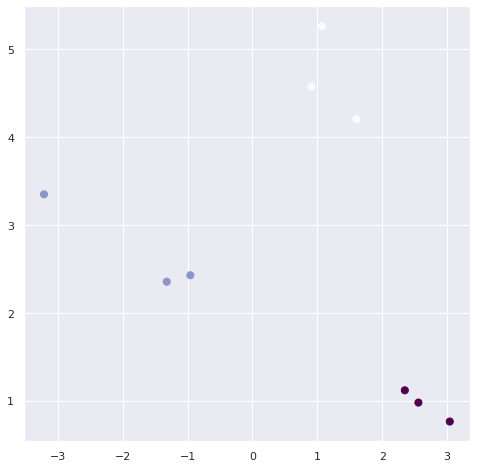

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.814815  0.261891
FM   0.884885  0.162798
HCV  0.859793  0.198282
MI   0.871795  0.181309
test 
          Mean       STD
2                      
ARI  0.666667  0.471405
FM   0.000000  0.000000
HCV  0.859793  0.198282
MI   0.666667  0.471405
            jaccard_index                      1.0
               rand_index                      1.0
            adjrand_index                      1.0
    fowlkes_mallows_index                      1.0
                 fmeasure                      1.0
             purity_index                      1.0
     classification_error                      0.0
        czekanowski_index                      1.0
               dice_index                      1.0
           sorensen_index                      1.0
    rogers_tanimoto_index                      1.0
          southwood_index                      1.0
      pearson_correlation      0.00

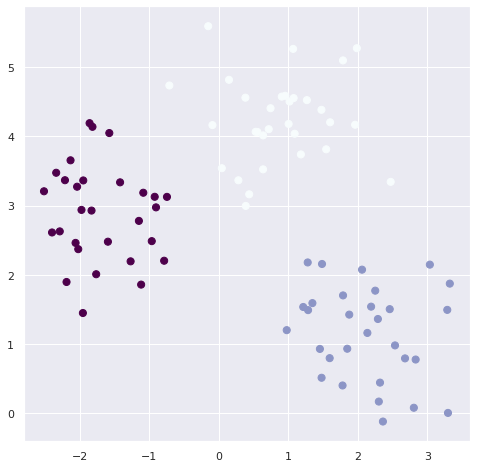

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.966862  0.024043
FM   0.978146  0.015815
HCV  0.958469  0.029590
MI   0.957250  0.030303
test 
          Mean       STD
2                      
ARI  0.964484  0.050227
FM   0.975677  0.034397
HCV  0.965082  0.049382
MI   0.963442  0.051701
            jaccard_index       0.9558052434456928
               rand_index       0.9852684144818976
            adjrand_index       0.9664753465150576
    fowlkes_mallows_index        0.977403365442481
                 fmeasure       0.9774032937571812
             purity_index       0.9888888888888889
     classification_error     0.011111111111111072
        czekanowski_index       0.9774032937571812
               dice_index       0.9774032937571812
           sorensen_index       0.9774032937571812
    rogers_tanimoto_index       0.9709645669291339
          southwood_index       21.627118644067796
      pearson_correlation    2.7423

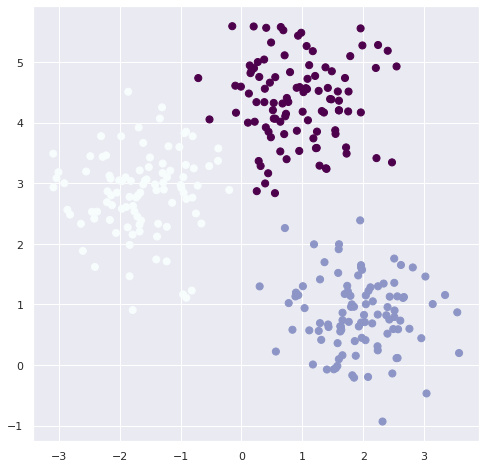

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.975274  0.013600
FM   0.983440  0.009108
HCV  0.965589  0.014970
MI   0.965259  0.015312
test 
          Mean       STD
2                      
ARI  0.980110  0.014065
FM   0.986613  0.009466
HCV  0.972881  0.019177
MI   0.972183  0.019670
            jaccard_index        0.973687707641196
               rand_index       0.9911705685618729
            adjrand_index       0.9800680223095938
    fowlkes_mallows_index       0.9866684711060294
                 fmeasure       0.9866684621599785
             purity_index       0.9933333333333334
     classification_error     0.006666666666666599
        czekanowski_index       0.9866684621599785
               dice_index       0.9866684621599785
           sorensen_index       0.9866684621599785
    rogers_tanimoto_index       0.9824956902267604
          southwood_index       37.005050505050505
      pearson_correlation   2.19977

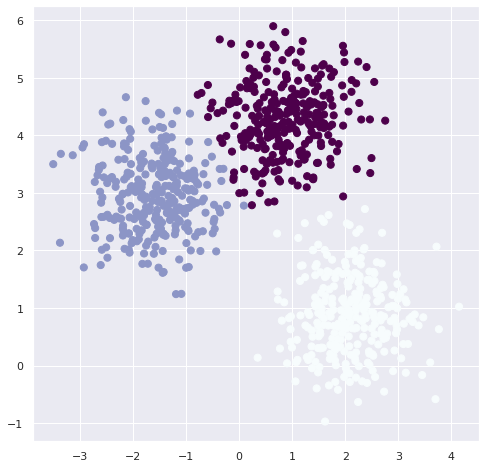

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.968604  0.002281
FM   0.979040  0.001527
HCV  0.948712  0.003699
MI   0.948569  0.003767
test 
          Mean       STD
2                      
ARI  0.960333  0.008275
FM   0.973500  0.005522
HCV  0.938934  0.012081
MI   0.938609  0.012364
            jaccard_index       0.9527700177774553
               rand_index       0.9839105178593499
            adjrand_index       0.9637596808810674
    fowlkes_mallows_index        0.975813856219015
                 fmeasure       0.9758138532481672
             purity_index       0.9877777777777778
     classification_error     0.012222222222222245
        czekanowski_index       0.9758138532481672
               dice_index       0.9758138532481672
           sorensen_index       0.9758138532481672
    rogers_tanimoto_index       0.9683305802816627
          southwood_index       20.172991242894454
      pearson_correlation    2.6527

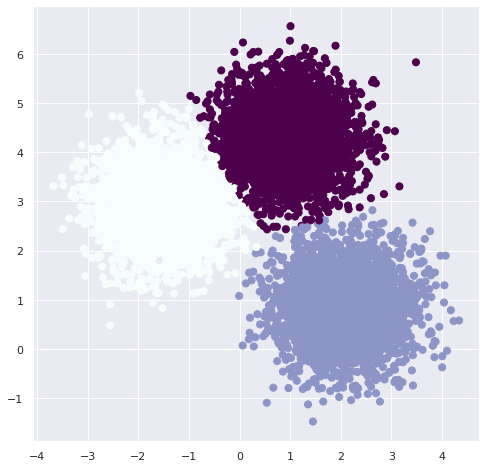

           n_clusters  k
0  KMeans__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.958143  0.001615
FM   0.972095  0.001078
HCV  0.930206  0.002188
MI   0.930212  0.002206
test 
          Mean       STD
2                      
ARI  0.959608  0.001403
FM   0.973080  0.000926
HCV  0.932288  0.001923
MI   0.932308  0.001935
            jaccard_index       0.9467254591912833
               rand_index       0.9817596276129447
            adjrand_index       0.9589549065309374
    fowlkes_mallows_index       0.9726337679788709
                 fmeasure       0.9726337678704586
             purity_index       0.9861111111111112
     classification_error      0.01388888888888884
        czekanowski_index       0.9726337678704586
               dice_index       0.9726337678704586
           sorensen_index       0.9726337678704586
    rogers_tanimoto_index       0.9641727574712157
          southwood_index       17.770692057028132
      pearson_correlation    2.6317

In [ ]:
hyper_cluster('KMeans')